In [2]:
import os
os.chdir(os.path.expanduser('~/My Drive/dirclip-private/core'))

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [275]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from functools import partial
from scipy.special import logsumexp

In [77]:
# load posterior grids
grids = np.load('../data/grids.npy', allow_pickle=True).item()
print(grids.keys())

# rescale posterior to the full dataset size
# almost all distributions densities were averaged over the num. of images, except the normal prior
n_train = 50_000
for key in grids.keys():
    if key not in ['acc', 'norm_prior']:
        grids[key] *= n_train

dict_keys(['acc', 'categ', 'dir_prior', 'dirclip_prior', 'max_prob', 'min_prob', 'ndg_like', 'ndg_post', 'ndg_prior', 'norm_prior'])


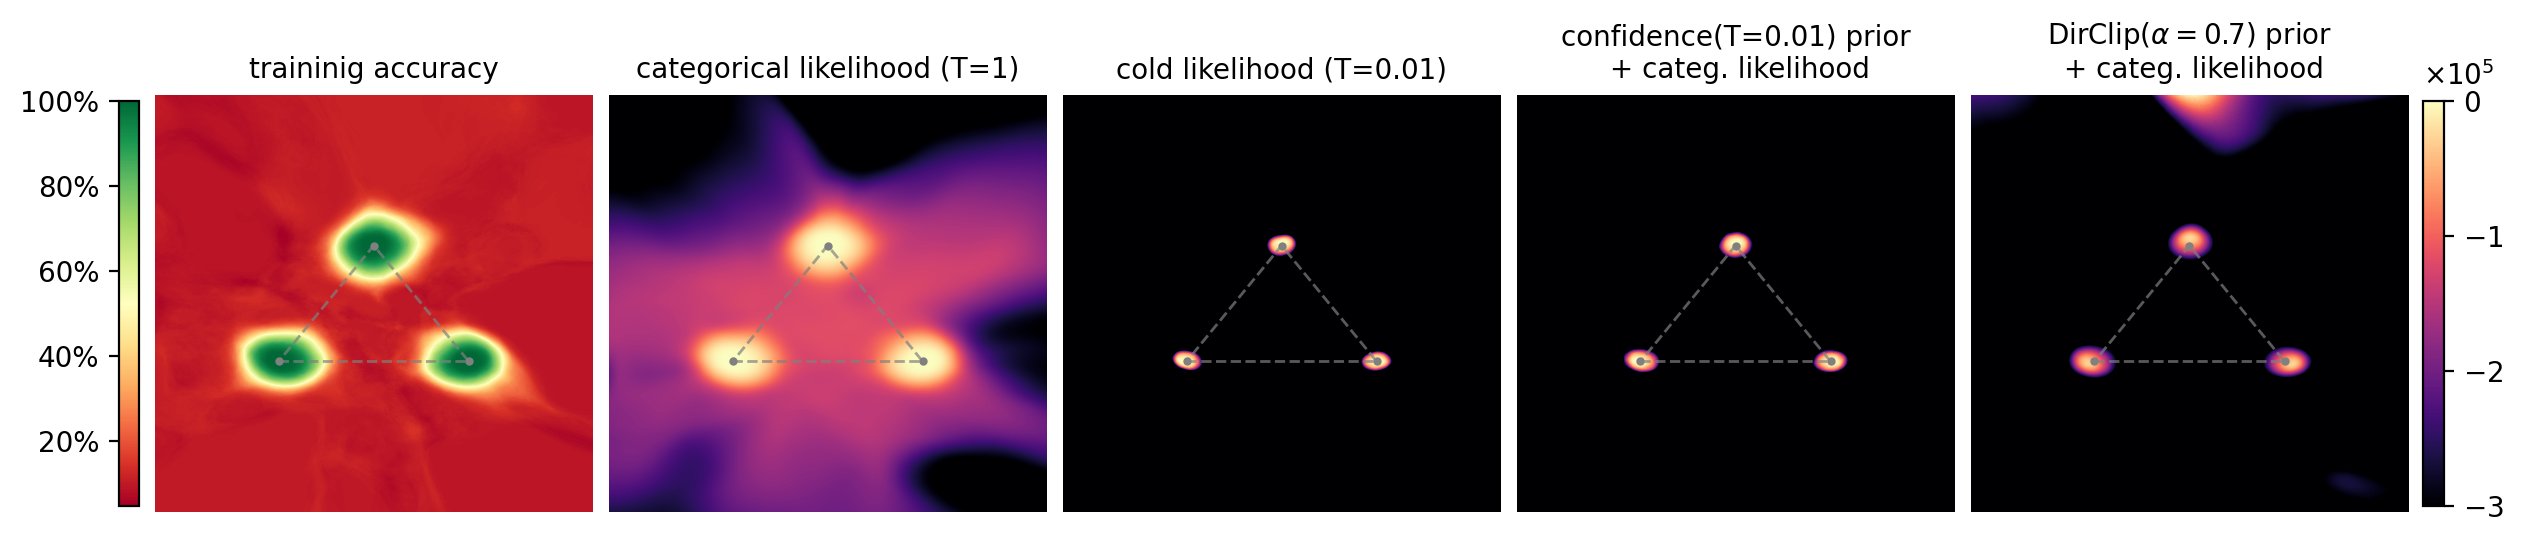

CPU times: user 833 ms, sys: 8.57 ms, total: 841 ms
Wall time: 311 ms


In [368]:
%%time
fig, axs = plt.subplots(1, 5, figsize=[12.5, 2.6], layout='constrained')
extent = [-1-margin, 1+margin, -margin, 1+margin]
img_kwargs = dict(origin='lower', extent=extent, aspect='auto')
loss_kwargs = dict(cmap='magma', vmin=-300_000, vmax=0)
acc_kwargs = dict(cmap='RdYlGn')

# plot accuracy
axs[0].set_title('traininig accuracy', fontsize=10)
img = axs[0].imshow(grids['acc'], **img_kwargs, **acc_kwargs)
cbar = plt.colorbar(img, ax=axs[0], pad=0.035, aspect=20, shrink=0.97, location='left', format=lambda x, _: f'{x:.0%}')

# plot posteriors
T = 0.01
alpha_old = 0.8
alpha = 0.7 # original DirClip posterior is alpha=0.8, ie multiplied by 0.2
use_norm_prior = 0
to_plot = OrderedDict((
    ('categorical likelihood (T=1)', use_norm_prior*grids['norm_prior'] + grids['categ']),
    (f'cold likelihood ({T=})', use_norm_prior*grids['norm_prior']/T + grids['categ']/T),
    (f"confidence({T=}) prior\n + categ. likelihood", use_norm_prior*grids['norm_prior']/T + grids['categ'] + grids['max_prob']*(1/T-1)),
    (f"DirClip($\\alpha={alpha}$) prior\n + categ. likelihood", use_norm_prior*grids['norm_prior']/T + grids['categ'] + grids['dirclip_prior']/(0.8-1)*(alpha-1)),
))
for i, (key, grid) in enumerate(to_plot.items()):
    ax = axs[1+i]
    ax.set_title(key, fontsize=10)
    grid -= scipy.special.logsumexp(grid)
    img = ax.imshow(grid, **img_kwargs, **loss_kwargs)
    
# posterior colorbar
cbar = plt.colorbar(img, ax=axs[-1], pad=0.035, aspect=20, shrink=0.97, location='right')
cbar.set_ticks((0, -100_000, -200_000, -300_000))
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.yaxis.OFFSETTEXTPAD = 6

# triangles
for ax in axs.flatten():
    ax.plot([-1, 1, 0, -1], [0, 0, 1, 0], ls='--', c='grey', linewidth=1, alpha=0.7)
    ax.scatter([-1, 1, 0], [0, 0, 1], marker='o', c='grey', s=4)
    ax.axis('off')

# plt.savefig('../plots/loss_landscape_5x.pdf')
plt.show()